## Import Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab.patches import cv2_imshow

## Functions

In [23]:
def warp_perspective(src_image, inv_transform, new_image_size):
    height, width = new_image_size
    dst_image = np.zeros((height, width, 3))
    src_width, src_height, _ = src_image.shape

    # calculate new cartesian coordinates
    homogeneous_coordinate = np.array([[i, j, 1] for i in range(width) for j in range(height)])
    mapped_homogeneous_coordinate = inv_transform.dot(homogeneous_coordinate.T).T
    mapped_cartesian_coordinates = mapped_homogeneous_coordinate[:, :-1] / mapped_homogeneous_coordinate[:, -1].reshape(-1, 1)

    # interpolate
    int_mapped_cartesian_coordinates = mapped_cartesian_coordinates.astype(int)
    local_loc = mapped_cartesian_coordinates - int_mapped_cartesian_coordinates
    for i in range(width):
        for j in range(height):
            index = i * height + j
            mapped_i, mapped_j = int_mapped_cartesian_coordinates[index]

            # if True or 0 < mapped_i < src_width and 0 < mapped_j < src_height:
            x, y = local_loc[index]
            f = np.array([[src_image[mapped_j, mapped_i], src_image[mapped_j+1, mapped_i]],
                [src_image[mapped_j, mapped_i+1], src_image[mapped_j+1, mapped_i+1]]])
            dst_image[j, i, 0] = np.dot([1 - x, x], f[:, :, 0]).dot([[1 - y], [y]])
            dst_image[j, i, 1] = np.dot([1 - x, x], f[:, :, 1]).dot([[1 - y], [y]])
            dst_image[j, i, 2] = np.dot([1 - x, x], f[:, :, 2]).dot([[1 - y], [y]])

    return dst_image


def dist(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))


def transform_image(src_image, src_points):
    p1, p2, p3, p4 = src_points
    width = int((dist(p1, p2) + dist(p3, p4)) // 2)
    height = int((dist(p2, p3) + dist(p1, p4)) // 2)
    dst_points = np.array([[0, 0], [width - 1, 0], [0, height - 1], [width - 1, height - 1]], dtype=np.float32)
    transform = cv2.getPerspectiveTransform(src_points, dst_points)
    inv_transform = np.linalg.inv(transform)
    dst_image = warp_perspective(src_image, inv_transform, (height, width))
    return dst_image.astype('uint8')

## Load Image

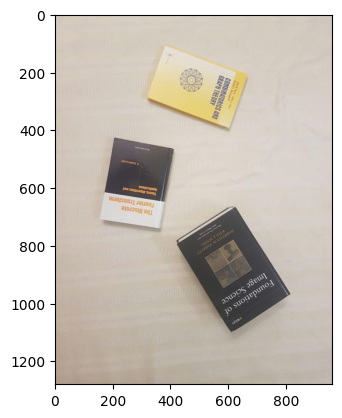

In [24]:
image = cv2.imread('books.jpg')

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

## Set Points

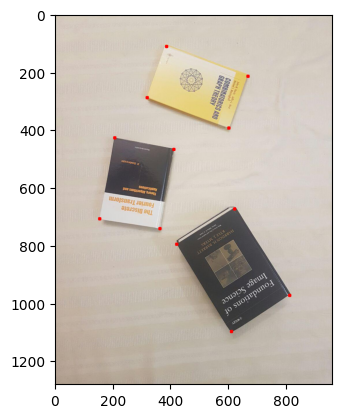

In [27]:
book1_edge_points = np.array([[362, 742], [154, 708], [410, 468], [206, 428]], dtype=np.float32)
book2_edge_points = np.array([[666., 215.], [600., 394.], [385., 112.], [318., 289.]], dtype=np.float32)
book3_edge_points = np.array([[810., 973.], [609., 1098.], [620., 674.], [420., 796.]], dtype=np.float32)

point_image = image.copy()
for i in range(len(book1_edge_points)):
    x, y = book1_edge_points[i].astype(int)
    point_image = cv2.circle(point_image, (x, y), radius=1, color=(0, 0, 255), thickness=10)
    x, y = book2_edge_points[i].astype(int)
    point_image = cv2.circle(point_image, (x, y), radius=1, color=(0, 0, 255), thickness=10)
    x, y = book3_edge_points[i].astype(int)
    point_image = cv2.circle(point_image, (x, y), radius=1, color=(0, 0, 255), thickness=10)

plt.imshow(cv2.cvtColor(point_image, cv2.COLOR_BGR2RGB))
plt.show()

## Project Books

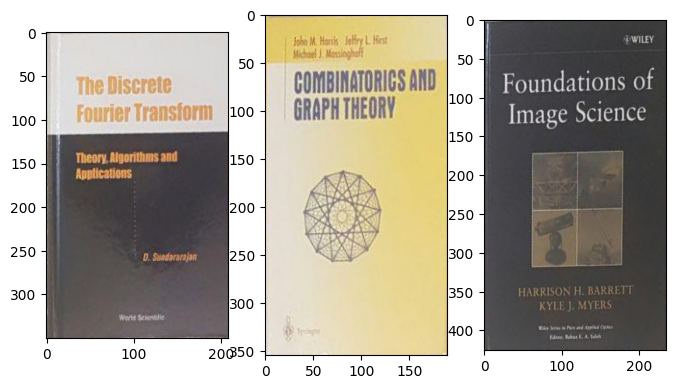

In [29]:
book1_dst_image = transform_image(image, book1_edge_points)
book2_dst_image = transform_image(image, book2_edge_points)
book3_dst_image = transform_image(image, book3_edge_points)

cv2.imwrite('res01.jpg', book1_dst_image)
cv2.imwrite('res02.jpg', book2_dst_image)
cv2.imwrite('res03.jpg', book3_dst_image)

plt.figure(figsize=(8, 6))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(book1_dst_image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(book2_dst_image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(book3_dst_image, cv2.COLOR_BGR2RGB))
plt.show()